# FAIRshake GTEx Tools and Datasets Evaluation Summary

In [2]:
import sys
import warnings
import numpy as np
from FAIRshakeAPI import models
import plotly.graph_objs as go
from collections import Counter
from tabulate import tabulate
from plotly import __version__
from django.db.models import Q
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
print (__version__)
print(sys.version)

3.1.1
3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## FAIRshake Tool Rubric
1. DESCRIPTION : The tool has a unique name and an informative description.
2. DOWNLOAD : The tool can be freely downloaded or accessed from a webpage.
3. ONTOLOGY : The tool utilizes a community-accepted ontology.
4. TUTORIAL : Tutorials for the tool are available on the tool's homepage.
5. SOURCE CODE : Source code is shared in a public repository and is documented.
6. VERSIONING : Previous versions of the tool are made available.
7. CONTACT: Contact information is provided for the creator(s) of the tool and information describing how to cite the tool is provided.
8. API : The tool can be accessed programmatically through an API and follows community standards for open APIs.
9. LICENSE : Licensing information is provided on the tool's homepage.

## FAIRshake Dataset Rubric
1. ID/ACCESSION : A standardized ID or accession number is used to identify the dataset.
2. METADATA : The dataset is described with metadata using a formal, broadly applicable vocabulary. 
3. EXPERIMENT : Information is provided on the experimental methods used to generate the data. 
4. REPOSITORY : The dataset is hosted in an established data repository, if a relevant repository exists. 
5. DOWNLOAD : The dataset can be downloaded for free from the repository. 
6. VERSIONING : Version information is provided for the dataset.
7. CONTACT: Contact information is provided for the creator(s) of the dataset. 
8. CITATION : Information is provided describing how to cite the dataset. 
9. LICENSE : Licensing information is provided on the dataset’s landing page. 



# GTEx FAIR Results: Tools

In [3]:
# Dictionary simplifies metric labels for bar graph 
metric_dict={12:"1. Description",13:"2. Download", 14: '3. Ontology', 15:'4. Tutorial', 
         16:'5. Source Code', 17:'6. Versioning', 18:'7. Contact', 19:'8. API', 20:'9. License'}

# Get results from GTEx project using tool rubric
query1=models.Answer.objects.filter(assessment__project__id=11, assessment__rubric__id=7).all() 

# Print # of resources and # of evalautions of these resources
print("++++++++++++++++++++")
# Number of resources
print(str(int(len(models.Project.objects.filter(id=11,digital_objects__type='tool').all())))+ " resource(s) total")
# Number evaluations
print(str(int(len(query1)/9))+" evaluation(s) total")
print("++++++++++++++++++++")

++++++++++++++++++++
5 resource(s) total
5 evaluation(s) total
++++++++++++++++++++


### Results Matrix: Answers for each tool

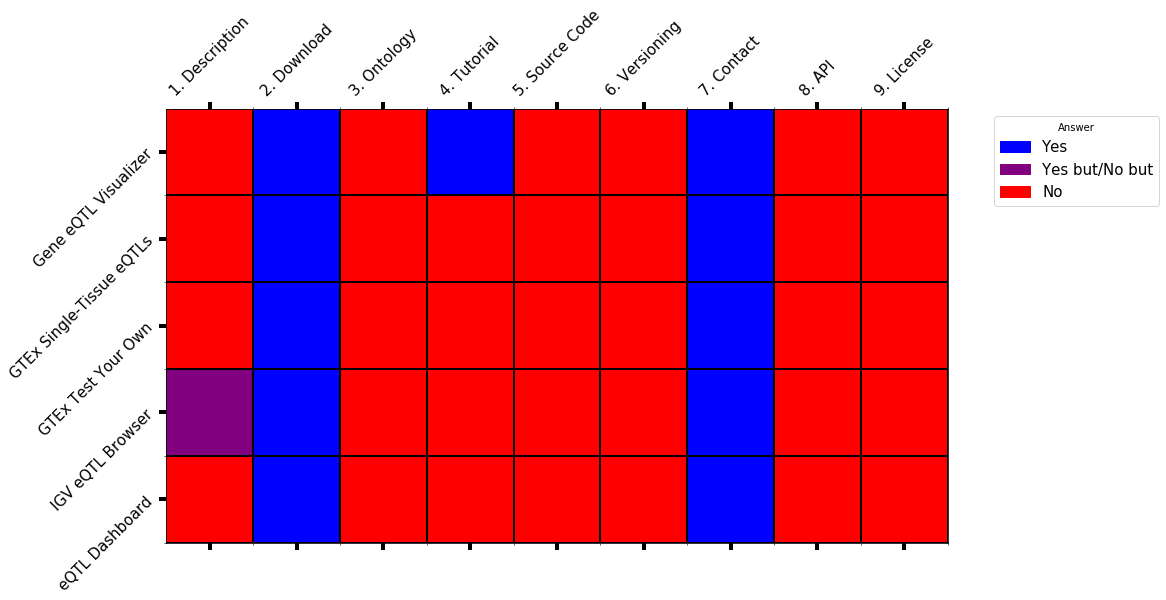

In [5]:
# Dictionary converts all answers to scores
answer_score_dict = {"yes":1,"yesbut":0.75,"nobut":0.25,"no":0}

# Function turns answers into scores
def Scoring(answers):
    scores=[]
    for ans in answers:
        scores.append(answer_score_dict[ans])
    return(scores)

# Dictionary simplifies metric labels for bar graph (tools)
tool_metric_dict={12:"1. Description",13:"2. Download", 14: '3. Ontology', 15:'4. Tutorial', 
         16:'5. Source Code', 17:'6. Versioning', 18:'7. Contact', 19:'8. API', 20:'9. License'}

# Answers for all tools in project 
tool_object_ids=models.Project.objects.filter(id=11).values_list('digital_objects',flat=True)
tool_unique_metrics=np.unique(query1.values_list('metric',flat=True))
tool_answers=[]
tool_objects_assessed=[]
for ID in tool_object_ids:
        responses=models.Answer.objects.filter(assessment__target__id=ID,assessment__rubric__id=7).values_list("answer",flat=True)
        if len(responses)>0:
            tool_answers.append(np.array(Scoring(responses)))
            tool_objects_assessed.append(ID)

# Create color map to visualize each tool and the answers to each metric
def colorMap(answer_vec,metric_dict,unique_metrics,objects_assessed,yaxis_cutoff):
    cmap = colors.ListedColormap(['red', 'purple','blue'])
    bounds = [0,0.26,0.76,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.matshow(answer_vec, cmap=cmap, norm=norm)

    ax.xaxis.set_ticks(np.arange(0.5, 9.5, 1) - 0.5, minor=True)
    ax.xaxis.set(ticks=np.arange(0, 9, 1), ticklabels=[metric_dict[x] for x in unique_metrics])
    ax.yaxis.set_ticks(np.arange(0.5, yaxis_cutoff, 1) - 0.5, minor=True)
    ax.yaxis.set(ticks=np.arange(0, yaxis_cutoff-0.5, 1),ticklabels=[models.DigitalObject.objects.filter(id=x).values_list('title',flat=True).get() for x in objects_assessed])
    ax.tick_params(axis='both', labelsize=15,rotation=45,width=4,length=7)
    minor_locator = FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
    ax.xaxis.set_minor_locator(minor_locator)
    ax.yaxis.set_minor_locator(minor_locator)
    plt.grid(which='minor',axis='both', linestyle='-', color='k',linewidth=2)
    legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                             label='Yes'),
                        Patch(facecolor='purple', edgecolor='purple',
                             label='Yes but/No but'),
                           Patch(facecolor='red', edgecolor='r',
                             label='No')]
    plt.legend(handles=legend_elements, title="Answer",bbox_to_anchor=(1.05, 1), loc=2,prop={'size': 15})
    plt.show()
    
colorMap(tool_answers,tool_metric_dict,tool_unique_metrics,tool_objects_assessed,5.5)

### Tool Rubric: Average answer for each question 

In [6]:
# Find average score for each question 

# Build bar graph
def QuestionBarGraphs(metric_dict,metric_count_dict):
    hist=[go.Bar(x=list([metric_dict[x] for x in metric_count_dict.keys()]),y=list(metric_count_dict.values()))]
    layout = go.Layout(title="Average answer for each question",xaxis=dict(title="Metric",titlefont=dict(size=16),tickfont=dict(size=12)),yaxis=dict(title='Mean FAIR score (yes=1,yesbut=0.75,nobut=0.25,no=0)',titlefont=dict(size=16)))
    fig = go.Figure(data=hist, layout=layout)
    iplot(fig)

# Function returns dictionary of each metric and its mean FAIR score in project
def QuestionBreakdown(query, metric_dict):
    metric_ids=iter(np.array(query.values_list('metric',flat=True)))
    answers=iter(np.array(query.values_list('answer',flat=True)))
    scores=Scoring(answers)
    d={}
    k = list(zip(metric_ids, scores))
    for (x,y) in k:
        if x in d:
            d[x] = d[x] + y 
        else:
            d[x] = y
    average_score={}
    for key, value in d.items():
        average_score[key]=value/(len(scores)/9)
    QuestionBarGraphs(metric_dict,average_score)  
    return(average_score)

# Input   
average_score_per_question=QuestionBreakdown(query1,tool_metric_dict)

### Average FAIR score for each tool

In [8]:
# Find average score for each digital object 

# Find each object in project and its mean FAIR score
object_score_dict={}
for ID in tool_object_ids:
    answers=list(models.Answer.objects.filter(assessment__target__id=ID,assessment__rubric__id=7).values_list("answer",flat=True))
    if len(answers)>0:
        scores=Scoring(answers)
        mean_score=np.mean(scores)
        object_score_dict[models.DigitalObject.objects.filter(id=ID).values_list('title', flat=True).get()]=mean_score

# Build Bar chart 
def DigitalObjectBarGraph(scores_dict):
    action_dict={}
    sorted_d = sorted((value,key) for (key,value) in scores_dict.items())
    for kv in sorted_d:
        if kv[0]<0.5:
            action_dict[kv[1]]='Low FAIR score'
        if kv[0]>=0.5 and kv[0]<=0.75:
            action_dict[kv[1]]='Moderate FAIR score'
        if kv[0]>0.75:
            action_dict[kv[1]]='Satisfactory FAIR score'
    scores = [sorted_d[x][0] for x in range(0,len(sorted_d))]
    objects=[sorted_d[x][1] for x in range(0,len(sorted_d))]
    all_trace=[]
    for result in [('Low FAIR score','rgba(255,10,10,1)'),('Moderate FAIR score','rgba(132,0,214,1)'),('Satisfactory FAIR score','rgba(0,0,214,1)')]:
        X=[]
        Y=[]
        for obj in objects:
            if action_dict[obj]==result[0]:
                X.append(obj)
                Y.append(scores_dict[obj])
        trace=go.Bar(x=X, y=Y,name=result[0],marker=dict(color=result[1]))
        all_trace.append(trace)
    layout=go.Layout(title="Average answer for each resource",xaxis=dict(title="Resources (n="+str(len(scores))+")",showticklabels=True,titlefont=dict(size=16)),showlegend=True,yaxis=dict(title='Mean FAIR score (yes=1,yesbut=0.75,nobut=0.25,no=0)',titlefont=dict(size=16)))
    fig = go.Figure(data=all_trace, layout=layout)
    iplot(fig)

# Input     
DigitalObjectBarGraph(object_score_dict) 

# GTEx FAIR Results: Datasets

In [10]:
# Dictionary simplifies metric labels for bar graph (datasets)
data_metric_dict={21:"1. ID/Accession",22:"2. Metadata", 23: '3. Experiment', 24:'4. Repository', 
         25:'5. Download', 26:'6. Versioning', 27:'7. Contact', 28:'8. Citation', 29:'9. License'}

# Get results from GTEx project using dataset rubric
query2=models.Answer.objects.filter(assessment__project__id=11, assessment__rubric__id=8).all() 

# Print # of resources and # of evalautions of these resources
print("++++++++++++++++++++")
# Number of resources
print(str(int(len(models.Project.objects.filter(id=11,digital_objects__type='data').all())))+ " resource(s) total")
# Number evaluations
print(str(int(len(query2)/9))+" evaluation(s) total")
print("++++++++++++++++++++")

++++++++++++++++++++
1 resource(s) total
1 evaluation(s) total
++++++++++++++++++++


### Results Matrix: Answers for each dataset

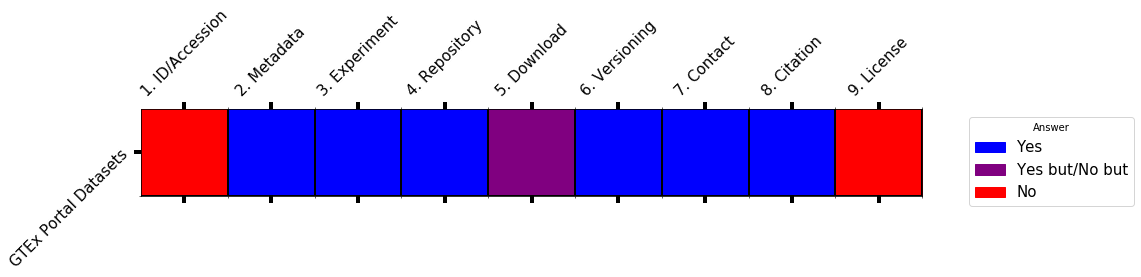

In [11]:
# Answers for all tools in project 
data_object_ids=models.Project.objects.filter(id=11).values_list('digital_objects',flat=True)
data_unique_metrics=np.unique(query2.values_list('metric',flat=True))
data_answers=[]
data_objects_assessed=[]
for ID in data_object_ids:
        responses=models.Answer.objects.filter(assessment__target__id=ID,assessment__rubric__id=8).values_list("answer",flat=True)
        if len(responses)>0:
            data_answers.append(np.array(Scoring(responses)))
            data_objects_assessed.append(ID)
            
# Input
colorMap(data_answers,data_metric_dict,data_unique_metrics,data_objects_assessed,1.5)

### Dataset Rubric: Average answer for each question 

In [12]:
# Find average score for each question 
datasets_average_score_per_question=QuestionBreakdown(query2,data_metric_dict)

### Average FAIR score for each dataset

In [13]:
# Find average score for each digital object 
data_object_score_dict={}
for ID in data_object_ids:
    answers=list(models.Answer.objects.filter(assessment__target__id=ID,assessment__rubric__id=8).values_list("answer",flat=True))
    if len(answers)>0:
        scores=Scoring(answers)
        mean_score=np.mean(scores)
        data_object_score_dict[models.DigitalObject.objects.filter(id=ID).values_list('title', flat=True).get()]=mean_score
        
DigitalObjectBarGraph(data_object_score_dict) 